In [4]:
from sklearn.metrics import recall_score, precision_score, f1_score, roc_curve, roc_auc_score
from sklearn import cluster
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

import pandas as pd
import numpy as np
import operator
import re
from time import sleep
import pprint
import pickle
from pymongo import MongoClient

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
def SaveDict(filename, mode, root):
    if filename[-4:]!=".txt":
        filename+=".txt"
    with open(filename, mode) as f:
        f.write(pprint.pformat(root))

def LoadDict(filename):
    if filename[-4:]!=".txt":
        filename+=".txt"
    with open(filename, "r") as f:
        return eval(f.read())

In [6]:
def hellinger_dist(vec1, vec2):
    dist = np.sqrt(0.5 * ((np.sqrt(vec1) - np.sqrt(vec2))**2).sum())
    return dist

In [7]:
def majority_vote(labels):
    votes = {}
    for i in labels:
        if i in votes:
            votes[i] += 1
        else:
            votes[i] = 1
    if len(votes)>0:
        return max(votes.iteritems(), key=operator.itemgetter(1))[0]
    else:
        return 5

In [8]:
def predict_user_group(name, validate=False):
    user_active = db.active_users.find_one({"name": name})
    user_not_active = db.user_merge.find_one({"name": name})
    if not validate and user_active:
        return user_active["label"]
    elif user_not_active:
        labels = []
        for retweet in user_not_active["tweet_ids"]:
            article = db.articles.find_one({"id": retweet})
            if article and "label" in article:
                labels.append(article["label"])
        return majority_vote(labels)
    else:
        return "user not found!"

In [9]:
def binarize(arr, tol):
    """
    Convert continous valued array to binary. 
    """
    arr[arr < tol] = 0
    arr[arr >= tol] = 1
    return arr

In [10]:
def article_score(article, lda_model, group):
    doc = article["clean_text"]
    doc_dict = gensim.corpora.Dictionary([doc])
    doc_corp = doc_dict.doc2bow(doc)
    doc_vec = lda_model[doc_corp]
    return gensim.matutils.cossim(group_topics[group], doc_vec)

In [11]:
client = MongoClient()
db = client.twitter

## News Recommendations for Each Group

In [9]:
def recommend_to_group(group):
    scores = []
    article_ids = []
    for article in db.rec_articles.find():
        article_ids.append(article["id"])
        if group != -1:
            scores.append(article_score(article, lda_model, group))    
        else:
            score = 0
            for i in range(6):
                score += article_score(article, lda_model, i)
            score /= 6.0
            scores.append(score)
    sorted_idx = np.argsort(-np.array(scores))[:]
    rec_list = []
    score_list = []
    for i in sorted_idx:
        rec_list.append(article_ids[i])
        score_list.append(scores[i])
    return rec_list, score_list

In [17]:
import gensim
from gensim import corpora, models
num_topics = 20
num_groups = 6
sample_size = 1000
lda_model = models.ldamodel.LdaModel.load('./data/ldamodels_bow_'+str(num_topics)+'.lda')
group_topics = pickle.load(open('./data/group_lda_bow_topics.pkl','rb'))

In [14]:
db.group_articles.drop()
for i in range(num_groups):
    articles, scores = recommend_to_group(i)
    db.group_articles.insert_one({"id": i, "articles": articles, "scores": scores})

In [15]:
articles, scores = recommend_to_group(-1)
db.group_articles.insert_one({"id": -1, "articles": articles, "scores": scores})

## Validation of Group Assignment

In [16]:
pred_group = []
true_group = []
for user in db.active_users.aggregate([{ "$sample": { "size": 1000 } } ]):
    pred_group.append(predict_user_group(user["name"], validate=True))
    true_group.append(user["label"])

In [335]:
print "recall: ", recall_score(true_group, pred_group, average='micro')
print "precision: ", precision_score(true_group, pred_group, average='micro')

0.472


## Validation of News Recommendation group level

In [12]:
def get_recall(true, pred, group_ids, tol=1.):
    true_binarized = binarize(true.copy(), tol=tol*np.median(true))
    pred_binarized = binarize(pred.copy(), tol=tol*np.median(pred))
    recalls = np.zeros(len(group_ids))
    for i in range(len(group_ids)):        
        group_true_binarized = true_binarized[i]
        group_pred = pred[i]
        group_pred_binarized = pred_binarized[i]
        recalls[i] = recall_score(group_true_binarized, group_pred_binarized)
    return np.mean(recalls[recalls > 0])

In [13]:
def get_precision(true, pred, group_ids, tol=1.):
    true_binarized = binarize(true.copy(), tol=tol*np.median(true))
    pred_binarized = binarize(pred.copy(), tol=tol*np.median(pred))
    precisions = np.zeros(len(group_ids))
    for i in range(len(group_ids)):        
        group_true_binarized = true_binarized[i]
        group_pred = pred[i]
        group_pred_binarized = pred_binarized[i]
        precisions[i] = precision_score(group_true_binarized, group_pred_binarized)
    return np.mean(precisions[precisions > 0])

In [18]:
import gensim
from gensim import corpora, models
num_topics = 20
num_groups = 6
sample_size = 1000
lda_model = models.ldamodel.LdaModel.load('./data/ldamodels_bow_'+str(num_topics)+'.lda')
group_topics = pickle.load(open('./data/group_lda_bow_topics.pkl','rb'))

In [19]:
rounds = 10

recall = np.zeros(rounds)
precision = np.zeros(rounds)
for r in range(rounds):
    pred = np.zeros((num_groups, sample_size))
    true = np.zeros((num_groups, sample_size))
    i = 0
    for article in db.articles.aggregate([{ "$sample": { "size": sample_size } } ]):
        for group in range(num_groups):
            if 'group '+str(group) in article:
                pred[group,i] = article_score(article, lda_model, group)
                true[group,i] = article["group "+str(group)]
        i += 1

    recall[r] = get_recall(true, pred, range(num_groups))
    precision[r] = get_precision(true, pred, range(num_groups))

In [20]:
print 'recall : %0.3f' %np.mean(recall[:])

recall : 0.659


In [21]:
print 'precision : %0.3f' %np.mean(precision[:])

precision : 0.665


In [22]:
pred = np.zeros((num_groups, sample_size))
true = np.zeros((num_groups, sample_size))
i = 0
for article in db.articles.aggregate([{ "$sample": { "size": sample_size } } ]):
    for group in range(num_groups):
        if 'group '+str(group) in article:
            pred[group,i] = article_score(article, lda_model, group)
            true[group,i] = article["group "+str(group)]
    i += 1
true_binarized = binarize(true.copy(), tol=np.median(true))

In [23]:
from sklearn import metrics
fpr = [[] for i in range(num_topics)]
tpr = [[] for i in range(num_topics)]
threshold = [[] for i in range(num_topics)]
roc_auc = np.zeros(num_topics)
for i in range(num_groups):
    f, t, thre= metrics.roc_curve(true_binarized[i], pred[i], pos_label=1)
    fpr[i] = f
    tpr[i] = t
    threshold[i] = thre
    
    roc_auc[i] = metrics.roc_auc_score(true_binarized[i], pred[i])

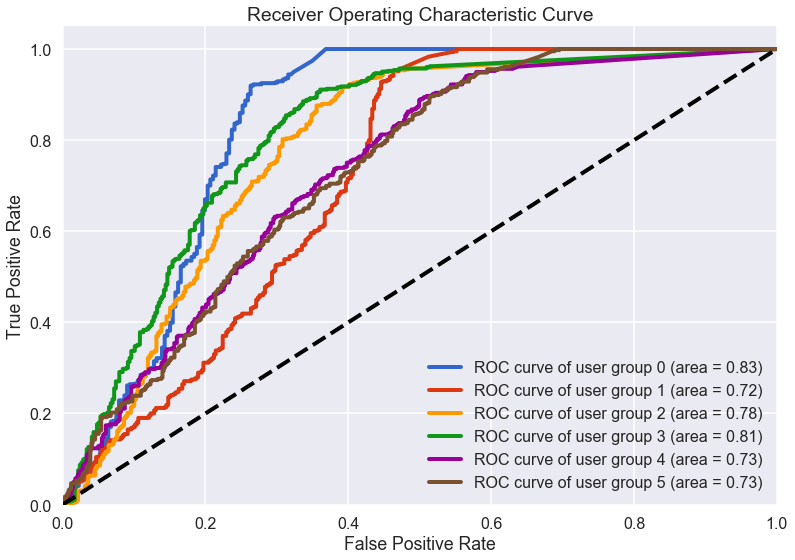

In [27]:
import seaborn as sns
sns.set_context("poster")
plt.figure()
with sns.axes_style("darkgrid"):
    colors = ["#3366cc", "#dc3912", "#ff9900", "#109618", "#990099", "#7a5230"]
    for i, color in zip(range(num_groups), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=4,
             label='ROC curve of user group {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()